# Asset Performance Management

Scenario: We have been given data from a Chemical Processing plant that uses its equipement for heating and cooling the chemicals that it manufactures for its customers.

We have around 5 years of data for its pump, chilling units and heat exchangers. (These individual components are not critical for our purposes.)

**Goal**: But looking at the sensors and instrumented data over 5 years of history, we have to see if the asset is performing well, or whether we are seeing anomalies.


Input file for this task: `APM_Asset_operations.csv`

### Preparatory Tasks

1. Read the input file
2. Format the data into a proper time series (with datetime) Timestamps and floats for the sensor values
3. Plot each of the sensors

### Anomaly Detection
4. Are you able to spot (visually) any anomalies?
5. Could there be threshold values that are being violated (above or below control limits?) for 'normal' operation?
5a. How to set thresholds to detect any of these anomalies.

6. (Optional): Can you try applying any of the `skelarn` outlier detection techniques? Does that catch the anomalies we say visually.

## Questions

* Focus on `Fuel Pressure`, `Lubricant Temperature` and `Tank Level`?
    * What metrics could we apply to these?
* Insights: Can we conclude that there are any alarms or anomalies in the data that we are examining?
* If you compute the rolling mean (moving averages) for these values and overlay them with the data, can you detect any anomalies?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from pandas.plotting import scatter_matrix
from sklearn.cluster import KMeans

In [2]:
%matplotlib inline

## Data Prep Tasks

In [51]:
df = pd.read_csv('APM_Asset_operations.csv')

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44002 entries, 0 to 44001
Data columns (total 16 columns):
Time                  44002 non-null object
Rotor_shaft_speed     44002 non-null object
Unit_Speed_RPM        44002 non-null object
Lower_shaft_speed     44002 non-null object
Line_Speed_RPM        44002 non-null object
Pressure_diff1        44002 non-null object
Pressure_diff2        44002 non-null object
Pressure_diff3        44002 non-null object
Pressure_loss         44002 non-null object
Inlet_Avg_Temp        44002 non-null object
Discharge_Avg_Temp    44002 non-null object
Discharge_Pressure    44002 non-null object
Outlet_Avg_Temp       44002 non-null object
Fuel_pressure         44002 non-null object
Lubricant_Temp        44002 non-null object
Oil_tank_level        44002 non-null object
dtypes: object(16)
memory usage: 5.4+ MB


In [53]:
df.describe()

,Time,Rotor_shaft_speed,Unit_Speed_RPM,Lower_shaft_speed,Line_Speed_RPM,Pressure_diff1,Pressure_diff2,Pressure_diff3,Pressure_loss,Inlet_Avg_Temp,Discharge_Avg_Temp,Discharge_Pressure,Outlet_Avg_Temp,Fuel_pressure,Lubricant_Temp,Oil_tank_level
count,44002,44002,44002,44002,44002,44002,44002,44002,44002,44002,44002,44002,44002,44002,44002,44002
unique,43997,1460,5938,28235,31969,39546,40029,40033,40721,39110,40188,12473,40827,13527,36315,36671
top,10/29/17 2:00,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2,916,916,927,927,781,781,781,781,781,781,781,781,781,781,781


In [54]:
df['Time'] =pd.to_datetime(df['Time'])

In [55]:
df = df.convert_objects(convert_numeric=True)

C:\Users\113011371\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44002 entries, 0 to 44001
Data columns (total 16 columns):
Time                  44002 non-null datetime64[ns]
Rotor_shaft_speed     43221 non-null float64
Unit_Speed_RPM        43221 non-null float64
Lower_shaft_speed     43221 non-null float64
Line_Speed_RPM        43221 non-null float64
Pressure_diff1        43221 non-null float64
Pressure_diff2        43221 non-null float64
Pressure_diff3        43221 non-null float64
Pressure_loss         43221 non-null float64
Inlet_Avg_Temp        43221 non-null float64
Discharge_Avg_Temp    43221 non-null float64
Discharge_Pressure    43221 non-null float64
Outlet_Avg_Temp       43221 non-null float64
Fuel_pressure         43221 non-null float64
Lubricant_Temp        43221 non-null float64
Oil_tank_level        43221 non-null float64
dtypes: datetime64[ns](1), float64(15)
memory usage: 5.4 MB


In [9]:
df.head()

,Time,Rotor_shaft_speed,Unit_Speed_RPM,Lower_shaft_speed,Line_Speed_RPM,Pressure_diff1,Pressure_diff2,Pressure_diff3,Pressure_loss,Inlet_Avg_Temp,Discharge_Avg_Temp,Discharge_Pressure,Outlet_Avg_Temp,Fuel_pressure,Lubricant_Temp,Oil_tank_level
0,2013-01-30 00:00:00,99.9686,5098.3989,101.1093,4721.8066,77.7725,76.7162,76.3368,167.0344,22.3443,329.2889,8.8556,492.9221,19.8115,54.6645,68.6119
1,2013-01-30 01:00:00,99.9924,5099.6123,101.5489,4742.3330,78.2751,76.8406,77.2332,167.0796,22.1642,329.4370,8.8732,494.6340,19.7604,54.6888,68.3893
2,2013-01-30 02:00:00,99.9839,5099.1792,101.5569,4742.7080,76.9854,76.0533,75.9253,167.3895,22.1140,328.9085,8.8686,493.6359,19.7733,54.7309,68.3634
3,2013-01-30 03:00:00,100.0077,5100.3926,102.1171,4768.8687,78.2802,77.3913,77.0074,168.4393,21.4434,328.3918,8.9081,493.5725,19.7667,54.6808,68.2874
4,2013-01-30 04:00:00,99.9924,5099.6123,102.1025,4768.1865,77.3884,76.7575,76.1018,168.6652,21.0625,328.3006,8.9256,494.1184,19.7841,54.5959,68.4671


In [10]:
df=df.fillna(df.mean())

In [11]:
df.isnull().values.sum()

0

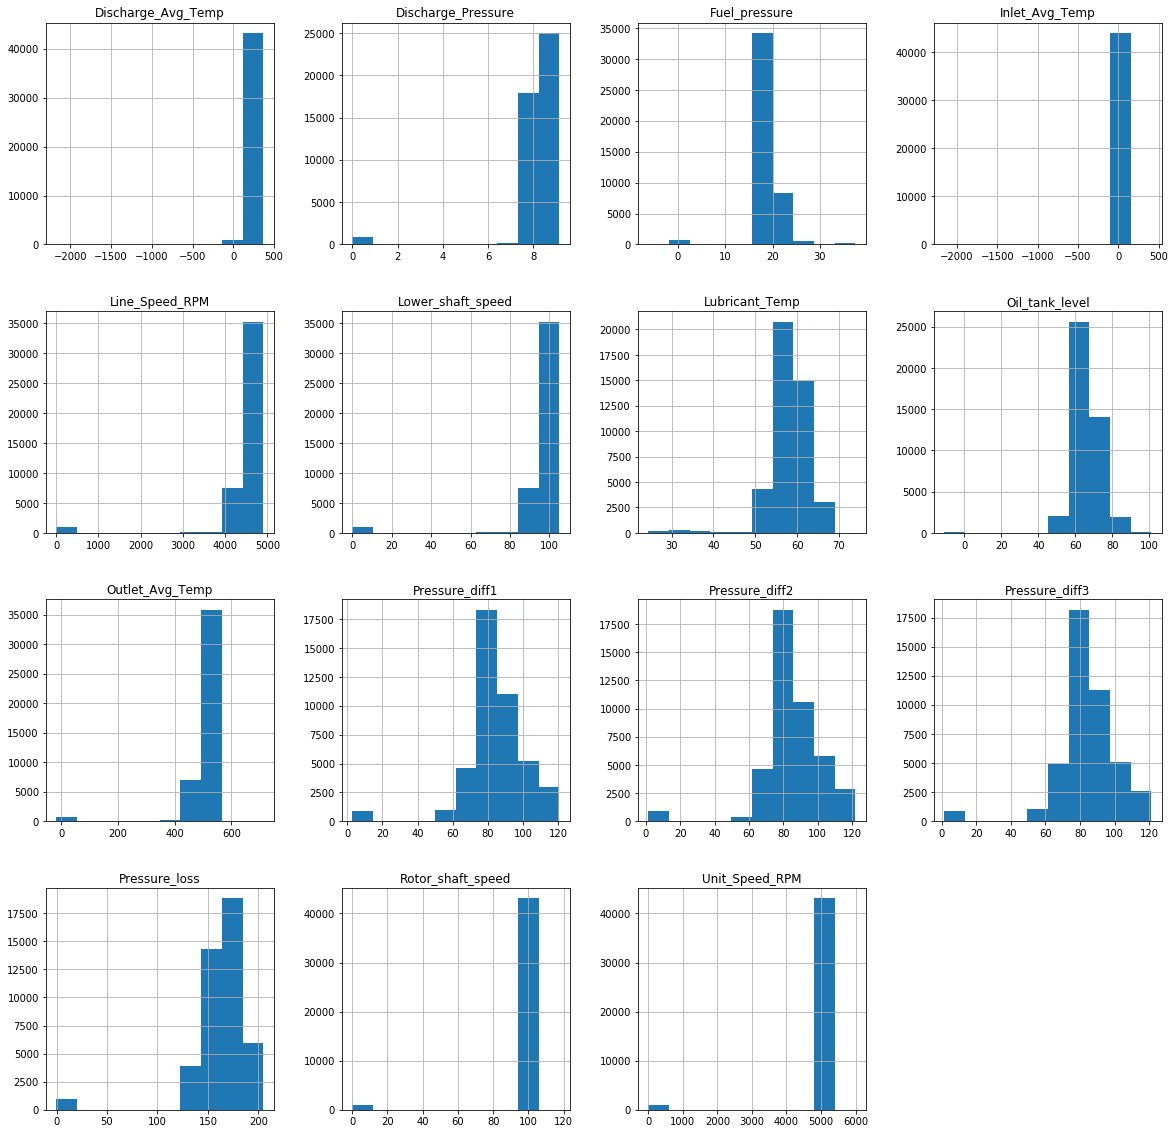

In [12]:
pd.DataFrame.hist(df, figsize=(20,20));

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000DAECDD8>,
      dtype=object)

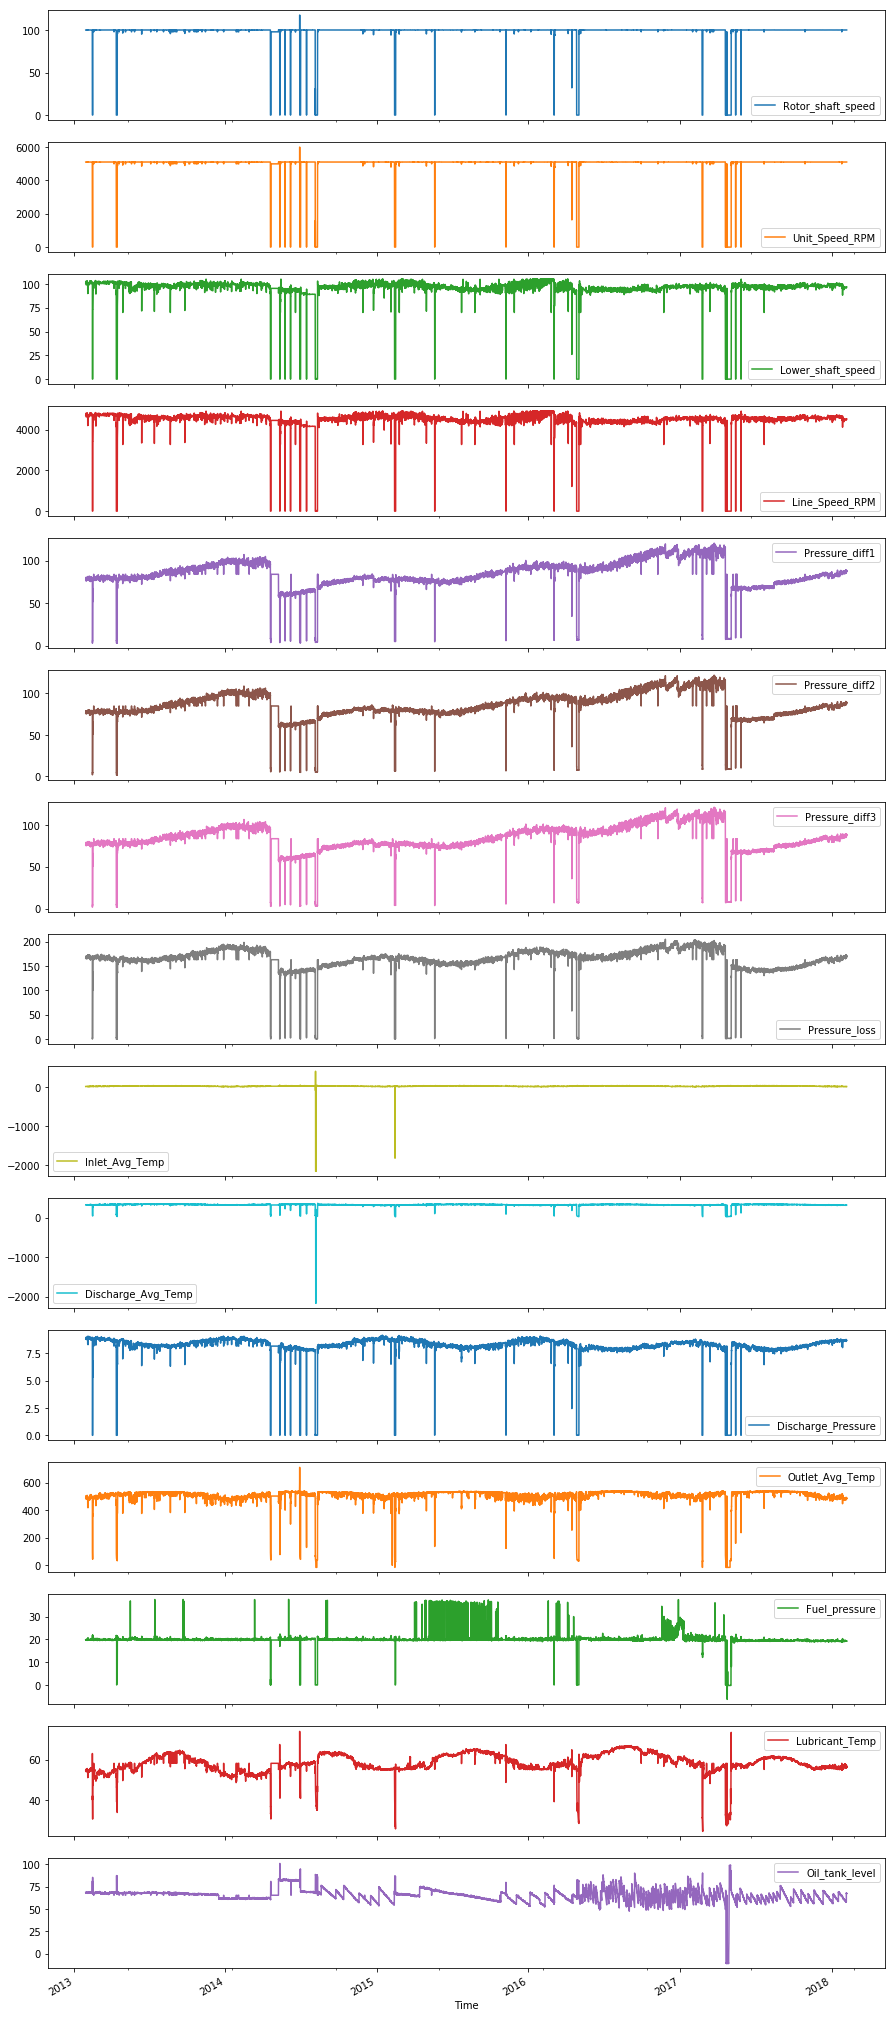

In [13]:
df.set_index('Time').plot(subplots=True, figsize=(15,40))

## Anomaly Detection Tasks

### Anomaly Detection
4. Are you able to spot (visually) any anomalies?
5. Could there be threshold values that are being violated (above or below control limits?) for 'normal' operation?
5a. How to set thresholds to detect any of these anomalies.

6. (Optional): Can you try applying any of the `skelarn` outlier detection techniques? Does that catch the anomalies we say visually.

##### 1. Yes, I can manually see/spot that there are several points with the timeline that all the instruments signals drastically drop

Normally the thresholds would be either set in the Controller as high and high high or low and low low Alarms as well as interlocks would be defined. The same would be done in the HMI/SCDA system that would notify the operator of the process needing intervention.

To help find these anomalies I used the correlation matrix and then sorted them to the highest correlation.
I am not an expert and can’t ask one regarding this process so I then use the highest correlating tags to do feature engineering and use k-means to find anomalies in that.

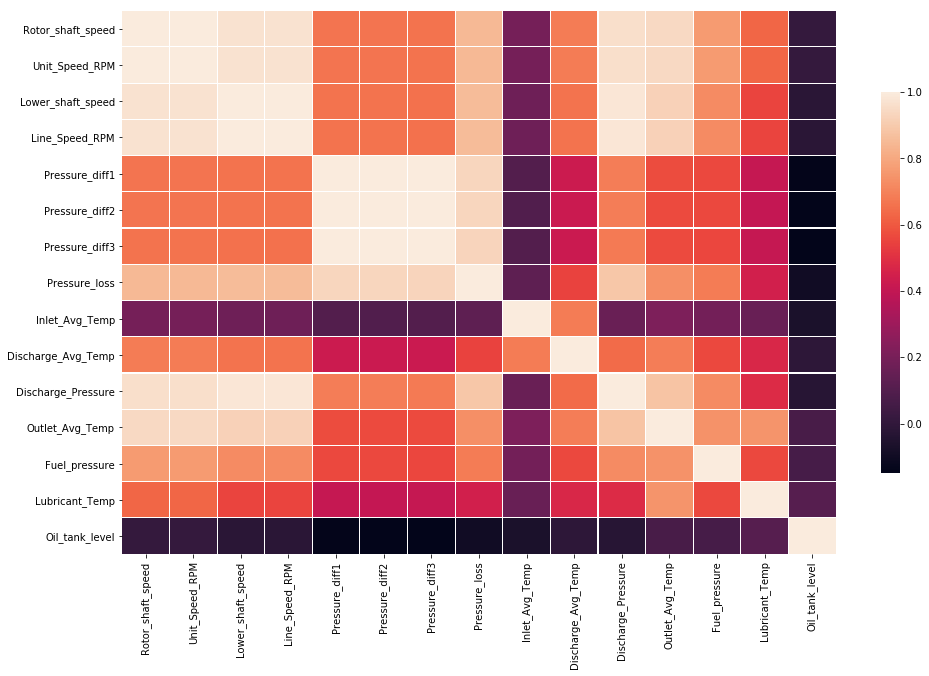

In [14]:
corr = df.corr()
plt.figure(figsize=(16, 10))
sns.heatmap(corr, xticklabels=corr.columns.values,
           yticklabels=corr.columns.values, linewidths=.08,
           cbar_kws={"shrink": .7})

In [15]:
# See the correlations in descending order

core = df.corr()
c1 = corr.abs().unstack()
c1.sort_values(ascending = False)

Oil_tank_level      Oil_tank_level        1.000000
Lubricant_Temp      Lubricant_Temp        1.000000
Unit_Speed_RPM      Unit_Speed_RPM        1.000000
Lower_shaft_speed   Lower_shaft_speed     1.000000
Line_Speed_RPM      Line_Speed_RPM        1.000000
Pressure_diff1      Pressure_diff1        1.000000
Pressure_diff2      Pressure_diff2        1.000000
Pressure_diff3      Pressure_diff3        1.000000
Inlet_Avg_Temp      Inlet_Avg_Temp        1.000000
Discharge_Avg_Temp  Discharge_Avg_Temp    1.000000
Discharge_Pressure  Discharge_Pressure    1.000000
Outlet_Avg_Temp     Outlet_Avg_Temp       1.000000
Fuel_pressure       Fuel_pressure         1.000000
Pressure_loss       Pressure_loss         1.000000
Rotor_shaft_speed   Rotor_shaft_speed     1.000000
Unit_Speed_RPM      Rotor_shaft_speed     0.999999
Rotor_shaft_speed   Unit_Speed_RPM        0.999999
Line_Speed_RPM      Lower_shaft_speed     0.999975
Lower_shaft_speed   Line_Speed_RPM        0.999975
Pressure_diff3      Pressure_di

In [16]:
X = df.as_matrix(columns=['Line_Speed_RPM', 'Discharge_Pressure'])

Text(0.5,1,'Elbow Curve')

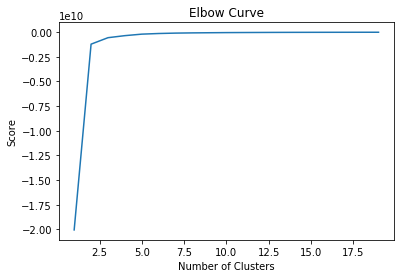

In [17]:
n_clusters = range(1, 20) # range for number of clusters

kmeans = [KMeans(n_clusters=i) for i in n_clusters]
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]

plt.plot(n_clusters,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')

In [18]:
k_means = KMeans(n_clusters=3,   # the number of clusters
             random_state=5) # set seed to get same results as your colleague

In [19]:
output = k_means.fit(X) # fit the model

In [20]:
labels = k_means.predict(X)

#### Plot model outputs: Line_Speed_RPM vs. Discharge_Pressure

In [21]:
colors = {0 : 'r',
          1 : 'g',
          2 : 'b',
          3 : 'y',
          4 : 'c'} # map integer label to color
label_color = [colors[l] for l in labels]

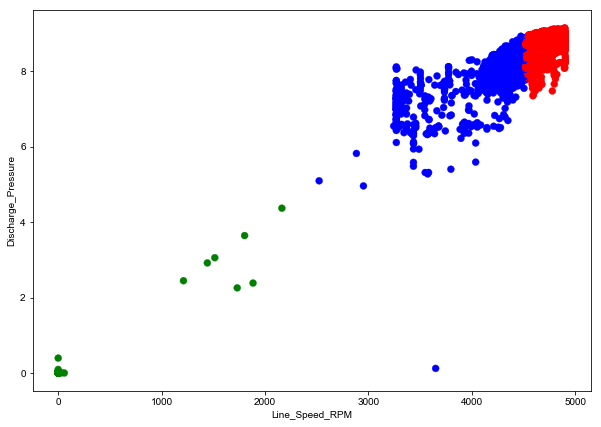

In [22]:
plt.figure('k-Means', figsize=(10,7))
plt.xlabel('Line_Speed_RPM')
plt.ylabel('Discharge_Pressure')
plt.style.use('seaborn')
cmap = 'tab10'
plt.scatter([X[:,0]], [X[:,1]], c=label_color, cmap=cmap)

#### Determining model performance

In [ ]:
from sklearn import metrics
print(metrics.silhouette_score(X, labels))

### Visualize results

In [56]:
#set the constants you need
consistency_const = 1.4826
thresh = 3

#rolling median calculation
df['Line_Speed_RPM'] = df.Line_Speed_RPM.rolling(480,center=True).median()

#rolling MAD calculation
df['Line_Speed_RPM_diff'] = abs(df.Line_Speed_RPM-df.Line_Speed_RPM)
df['Line_Speed_RPM_mad'] = df.Line_Speed_RPM_diff.rolling(480,center=True).median()

#rolling modified z-score calculation
df['rolling_z_score'] = pd.to_numeric((df.Line_Speed_RPM_diff /(df.Line_Speed_RPM_mad*consistency_const)) > thresh)

In [58]:
df = df.dropna()

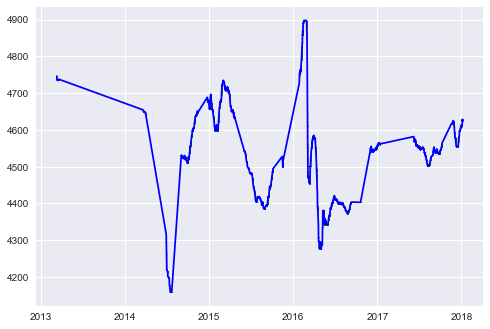

In [59]:
normal = df[df.rolling_z_score == 0]
anomaly = df[df.rolling_z_score == 1]

#normal data as green points
plt.plot_date(normal.Time, normal.Line_Speed_RPM, color='green',markersize=0.5)
#anomalies as red points
plt.plot_date(anomaly.Time, anomaly.Line_Speed_RPM, color='red',markersize=1)
#rolling median as blue line
plt.plot_date(df['Time'],df['Line_Speed_RPM'], color='blue',linestyle='solid', marker='None')

In [67]:
df = df[df.Line_Speed_RPM <4500]
normal = df[df.rolling_z_score == 0]
anomaly = df[df.rolling_z_score == 1]

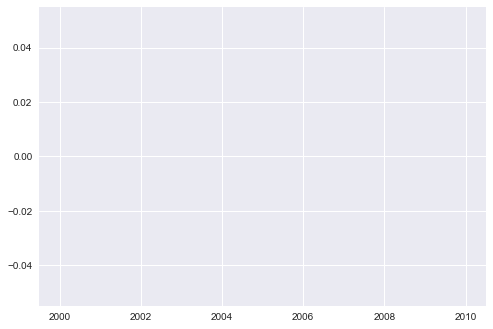

In [68]:
plt.plot_date(normal.Time, normal.Line_Speed_RPM, color='green',markersize=0.5)
plt.plot_date(anomaly.Time, anomaly.Line_Speed_RPM, color='red',markersize=1)
plt.plot_date(df['Time'],df['Line_Speed_RPM'], color='blue',linestyle='solid', marker='None')

# Conclusions and Recommendations

I have applied the anomaly detection for one tag only "Line_Speed_RPM" as this was the highest correlating tag with all the other tag / sensors. The same can be performed for the other highly correlated tags / sensors.

Using these unsupervised ML tools does give you a good look into the behavior of such a machine that you do not know. It also lends itself nicely to have discussions points prepared for discussion with an expert.